### Sales Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# read data
data_dir = r'C:\Users\Timothy Lim\Dropbox\Tim Y4S2\BT4222\Project\data'
sales_df = pd.read_excel(rf"{data_dir}\apple sales data.xlsx", 
                         sheet_name='Data', engine='openpyxl', usecols="B:E", skiprows=4,
                        names=['Quarter', 'iPhone', 'iPad', 'Mac'])

sales_df.head()

,Quarter,iPhone,iPad,Mac
0,1Q '12,37.04,15.43,5.20
1,2Q '12,35.06,11.80,4.02
2,3Q '12,26.03,17.04,4.02
3,4Q '12,26.91,14.04,4.92
4,1Q '13,47.79,22.86,4.06


In [3]:
sales_df.dtypes

Quarter     object
iPhone     float64
iPad       float64
Mac        float64
dtype: object

In [4]:
sales_df.shape

(28, 4)

In [5]:
sales_df.describe()

,iPhone,iPad,Mac
count,28.000000,28.000000,28.000000
mean,47.218214,13.751071,4.640357
std,14.433032,4.362983,0.611692
min,26.030000,8.920000,3.720000
25%,37.332500,10.310000,4.075000
50%,46.095000,12.850000,4.565000
75%,51.070000,15.602500,5.225000
max,78.290000,26.040000,5.710000


Data represents unit sales of Apple worldwide by product / operating segment.

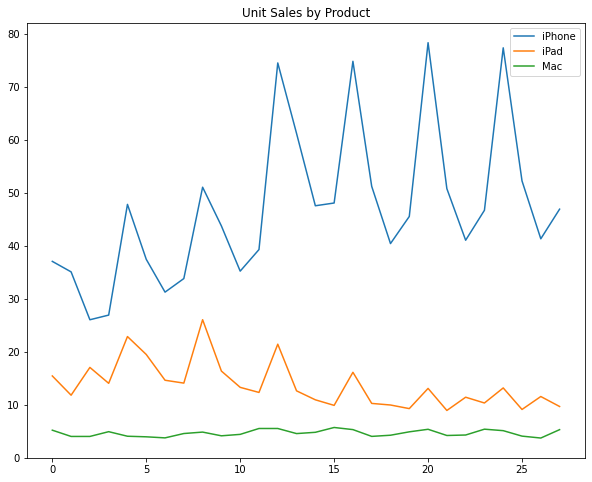

In [6]:
# plot sales
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 8))
axes.plot(sales_df.index, sales_df['iPhone'], label='iPhone')
axes.plot(sales_df.index, sales_df['iPad'], label='iPad')
axes.plot(sales_df.index, sales_df['Mac'], label='Mac')
axes.set_title("Unit Sales by Product")
axes.legend()

plt.show()

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


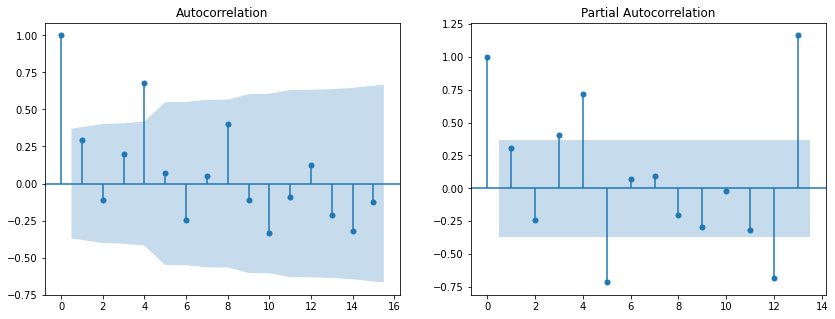

In [7]:
# acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    plot_acf(data, ax=axes[0])
    plot_pacf(data, lags=13, ax=axes[1])
    plt.show()

# iphone
plot_acf_pacf(sales_df['iPhone'])

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


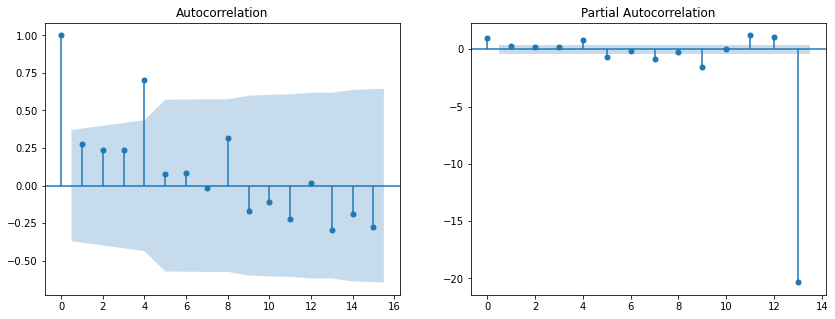

In [8]:
# iPad
plot_acf_pacf(sales_df['iPad'])

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


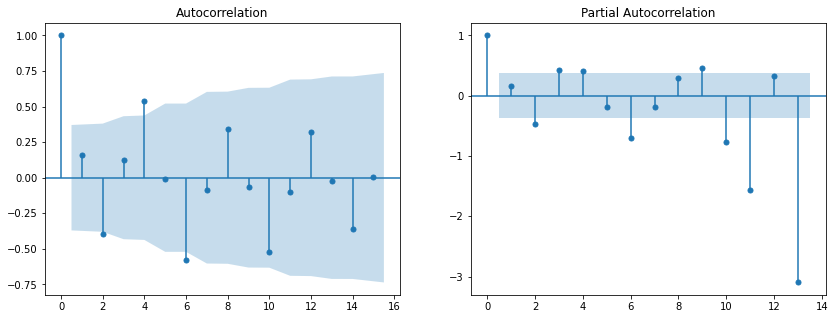

In [9]:
# mac
plot_acf_pacf(sales_df['Mac'])

ACF shows the correlation coefficients between a time series and its lagged values. Useful for identifying the order of MA term. 

PACF isolates the effects of time lag t-n on time t.  Useful for identifying the order of AR term.   
eg. regress y(t) = y(t-1) + y(t-2) + y(t-3), then PACF for time lag 3 is the coefficient of y(t-3). or something like this..

For all product lines, we can see that the ACF at the 4th lag is strongly positive. We should consider adding a seasonal component of size=4, since this corresponds to a year's worth of data also. 

Not sure about the PACF plots lol

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/  

https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

Anyway just use a grid search to find the optimal parameters for the time series. 

### Identifying SARIMA Order

In [10]:
# split train-test

train_size = 0.7
train_idx = int(train_size * len(sales_df))
train_df = sales_df.iloc[:train_idx]
test_df = sales_df.iloc[train_idx:]

print(train_df.shape)
print(test_df.shape)

(19, 4)
(9, 4)


In [11]:
train_df.tail()

,Quarter,iPhone,iPad,Mac
14,3Q '15,47.53,10.93,4.80
15,4Q '15,48.05,9.88,5.71
16,1Q '16,74.78,16.12,5.31
17,2Q '16,51.19,10.25,4.03
18,3Q '16,40.40,9.95,4.25


In [12]:
test_df.head()

,Quarter,iPhone,iPad,Mac
19,4Q '16,45.51,9.27,4.89
20,1Q '17,78.29,13.08,5.37
21,2Q '17,50.76,8.92,4.20
22,3Q '17,41.03,11.42,4.29
23,4Q '17,46.68,10.33,5.39


In [13]:
# specify range of values to iterate over
param_space = {'p': range(0, 5),  # AR terms
               'd': range(0, 2), 
               'q': range(0, 5), # MA terms
               'P': range(0, 5), 
               'D': range(0, 2),
               'Q': range(0, 5), 
               's': range(4, 12, 4)
              }

n_comb = 1
for v in param_space.items():
    n_comb *= len(v)

print(f'no. of models to try: {n_comb}')

no. of models to try: 128


In [14]:
import itertools as it
combinations = it.product(*(param_space[param] for param in param_space))
len(list(combinations))

5000

In [15]:
param_space

{'p': range(0, 5),
 'd': range(0, 2),
 'q': range(0, 5),
 'P': range(0, 5),
 'D': range(0, 2),
 'Q': range(0, 5),
 's': range(4, 12, 4)}

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools as it
import progressbar
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings('ignore')

run_search = False

def find_order(data, param_space, metric='mse'):
    '''
    helper method to return the best parameters for the SARIMAX model
    '''
    # convert param space into iterable
    combinations = it.product(*(param_space[param] for param in param_space))
    
    results_df = pd.DataFrame(columns=['p', 'd', 'q', 'P', 'D', 'Q', 'm', 'eval_metric'])
    
    bar = progressbar.ProgressBar(maxval=len(list(it.product(*(param_space[param] for param in param_space)))), 
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i = 0
    for combi in combinations:
        bar.update(i+1)
        # unpack parameters
        p = combi[0]
        d = combi[1]
        q = combi[2]
        
        P = combi[3]
        D = combi[4]
        Q = combi[5]
        m = combi[6]
       
        try:
            model = SARIMAX(endog=data, order=(p, d, q), seasonal_order=(P, D, Q, m),
                            trend='t', enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
        except: # give up
            continue
        
        if metric=='mse':
            fit_result = model_fit.mse
        if metric=='aic':
            fit_result = model_fit.aic
        if metric=='bic':
            fit_result = model_fit.bic
        
        # update results
        results_df.loc[len(results_df)] = [p, d, q, P, D, Q, m, fit_result]
        i += 1

    bar.finish()
    return results_df

if run_search: 
    iphone_order = find_order(train_df['iPhone'], param_space)

In [ ]:
iphone_order

In [155]:
# generate one-step forecasts

def get_forecasts(train_data, test_data, order, seasonal_order, n_steps=1, exog_train=None, exog_test=None):
    '''
    generates n-step forecasts for each obs in test data
    '''
    pointer = 0
    y_pred = pd.Series()
    
    while pointer < len(test_data):
        
        if exog_train is not None or exog_test is not None:
            model = SARIMAX(endog=train_data.append(test_data.iloc[:pointer]),
                           exog=exog_train.append(exog_test.iloc[:pointer]),
                           order=order,
                           seasonal_order=seasonal_order)
            res = model.fit()
            y_pred = y_pred.append(res.forecast(steps=n_steps, exog=exog_test.iloc[pointer]))
            
        else:
            model = SARIMAX(endog=train_data.append(test_data.iloc[:pointer]),
                           order=order,
                           seasonal_order=seasonal_order)

            res = model.fit()
            y_pred = y_pred.append(res.forecast(steps=n_steps))
        pointer += n_steps
    
    return y_pred



In [32]:
# iPhone sales forecasts
y_pred = get_forecasts(train_df['iPhone'], test_df['iPhone'],
                      (0, 1, 3), (3, 1, 1, 4))  
y_pred

19    41.622643
20    70.222499
21    57.585622
22    35.777736
23    46.223395
24    93.010837
25    46.398540
26    41.000251
27    45.481277
dtype: float64

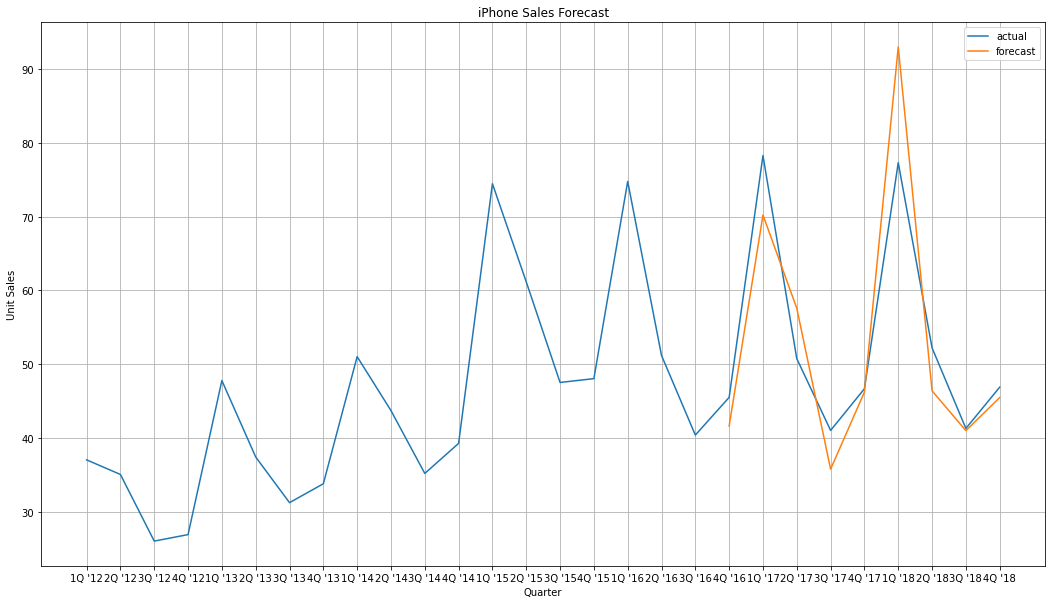

In [33]:
# plot
y_true = sales_df['iPhone']

fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], y_true, label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], y_pred, label='forecast')
plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("iPhone Sales Forecast")
plt.grid(True)
plt.legend()

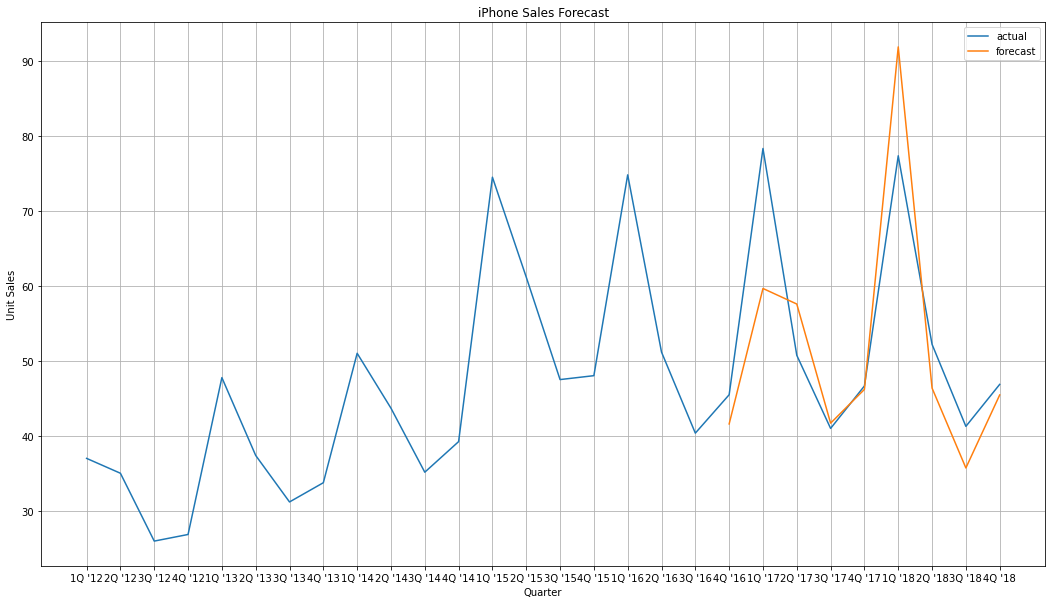

In [34]:
# two step forecasts
two_step = get_forecasts(train_df['iPhone'], test_df['iPhone'], (0, 1, 3), (3, 1, 1, 4), n_steps=2)

# plot
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], y_true, label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], two_step.iloc[:-1], label='forecast')
plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("iPhone Sales Forecast")
plt.grid(True)
plt.legend()

In [35]:
if run_search:
    ipad_order = find_order(train_df['iPad'], param_space)
    mac_order = find_order(train_df['Mac'], param_space)

In [36]:
ipad_order.sort_values('eval_metric').head()

NameError: name 'ipad_order' is not defined

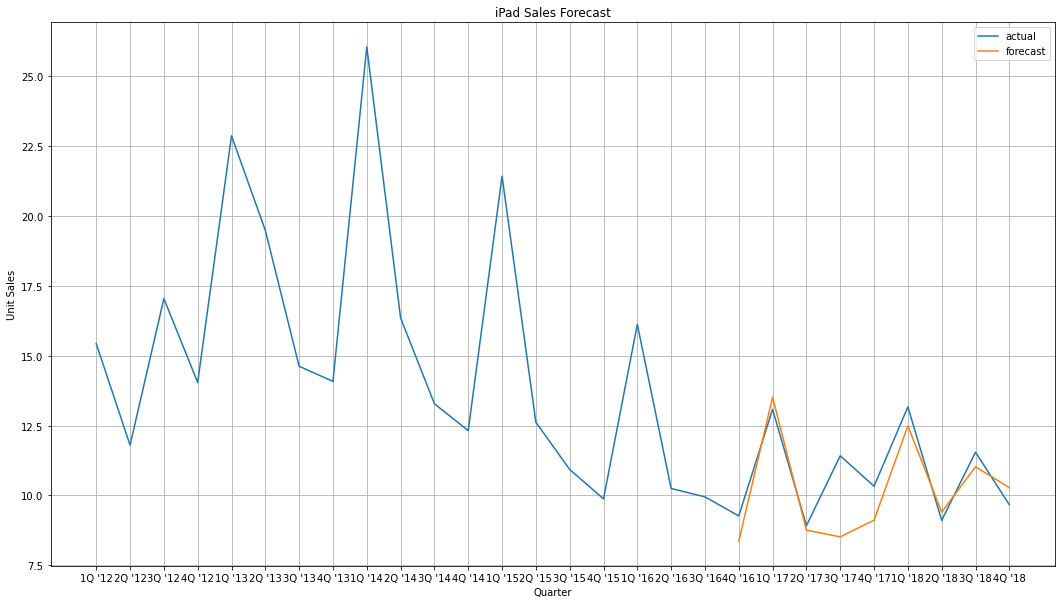

In [37]:
# iPad forecasts 
ipad_forecast = get_forecasts(train_df['iPad'], test_df['iPad'],
                             (1, 0, 2), (1, 0, 0, 4), n_steps=1)

# plot
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], sales_df['iPad'], label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], ipad_forecast, label='forecast')
plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("iPad Sales Forecast")
plt.grid(True)
plt.legend()

In [ ]:
mac_order.sort_values('eval_metric').head()

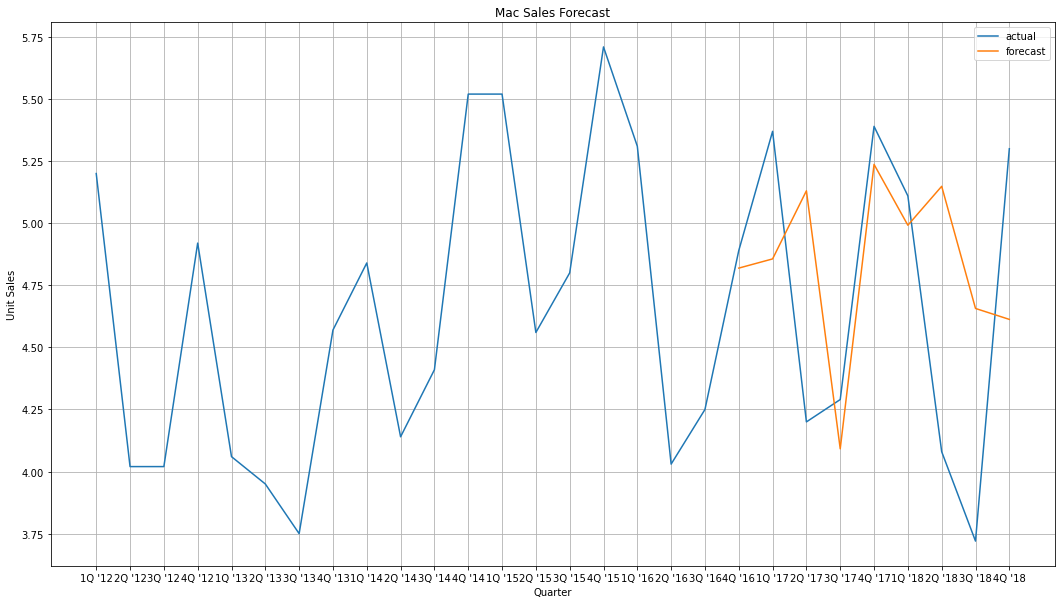

In [38]:
# mac forecasts 
mac_forecast = get_forecasts(train_df['Mac'], test_df['Mac'],
                             (1, 1, 3), (0, 0, 0, 4), n_steps=1)

# plot
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], sales_df['Mac'], label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], mac_forecast, label='forecast')
plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("Mac Sales Forecast")
plt.grid(True)
plt.legend()

I think the forecasts are all decent...Mac forecasts look worse but I think its the scale of the y-axis that makes it look as such. 

### Forecasting with exogeneous variables

SARIMAX using sentiment analysis from the preceding quarter as an exogeneous variable. Here, we use the sentiment extracted from the following models: 
* BERT
* vader
* NB with count vectorizer features
* NB with TF-ID features

In [184]:
# load data
cols = ['date', 'content', 'sentiment']
bert_sentiment = pd.read_csv(fr'{data_dir}\tweets_bert.csv', usecols=cols)
vader_sentiment = pd.read_csv(fr'{data_dir}\tweets_sentiment_vader.csv', usecols=cols)
countvect_sentiment = pd.read_csv(fr'{data_dir}\tweets_sentiment_countvect.csv', usecols=cols)
tfidf_sentiment = pd.read_csv(fr'{data_dir}\tweets_tfidf.csv', usecols=cols)

assert(bert_sentiment.shape==vader_sentiment.shape==countvect_sentiment.shape==tfidf_sentiment.shape)
print(bert_sentiment.shape)

(61450, 3)


In [132]:
def process_data(df): 
    
    # handle date column
    df.dropna(subset=['sentiment'], inplace=True)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z')
    df['year'] = df['date'].dt.year
    df['QTR_IDX'] = df['year'].astype('str').str.cat(df['date'].dt.quarter.astype(str), '_')
 
    # sentiment scoring
    sentiment_count = df.groupby(by='QTR_IDX')['sentiment'].value_counts(normalize=True)
    pos_mask = sentiment_count.index.get_level_values(level='sentiment')==1
    neg_mask = sentiment_count.index.get_level_values(level='sentiment')==-1
    
    pos = sentiment_count[pos_mask]
    pos.reset_index(level='sentiment', drop=True, inplace=True)
    pos.name = 'pos_sentiment'
    
    neg = sentiment_count[neg_mask]
    neg.reset_index(level='sentiment', drop=True, inplace=True)
    neg.name = 'neg_sentiment'
    
    return pd.concat([pos, neg], axis=1)

bert_sentiment_scores = process_data(bert_sentiment)
bert_sentiment_scores.head()

,pos_sentiment,neg_sentiment
QTR_IDX,,
2012_1,0.209259,0.192130
2012_2,0.196296,0.206481
2012_3,0.206579,0.213596
2012_4,0.200926,0.229630
2013_1,0.189352,0.234722


In [203]:
# align indexes
sales_df.index = bert_sentiment_scores.index[:-1]
sales_with_bert = pd.concat([sales_df, bert_sentiment_scores], axis=1)

sales_with_bert.head()

,Quarter,iPhone,iPad,Mac,pos_sentiment,neg_sentiment
2012_1,1Q '12,37.04,15.43,5.20,0.209259,0.192130
2012_2,2Q '12,35.06,11.80,4.02,0.196296,0.206481
2012_3,3Q '12,26.03,17.04,4.02,0.206579,0.213596
2012_4,4Q '12,26.91,14.04,4.92,0.200926,0.229630
2013_1,1Q '13,47.79,22.86,4.06,0.189352,0.234722


In [204]:
sales_with_bert['pos_sentiment'] = sales_with_bert['pos_sentiment'].shift(1)
sales_with_bert['neg_sentiment'] = sales_with_bert['neg_sentiment'].shift(1)
sales_with_bert.dropna(how='any', inplace=True)
sales_with_bert

,Quarter,iPhone,iPad,Mac,pos_sentiment,neg_sentiment
2012_2,2Q '12,35.06,11.80,4.02,0.209259,0.192130
2012_3,3Q '12,26.03,17.04,4.02,0.196296,0.206481
2012_4,4Q '12,26.91,14.04,4.92,0.206579,0.213596
2013_1,1Q '13,47.79,22.86,4.06,0.200926,0.229630
2013_2,2Q '13,37.43,19.48,3.95,0.189352,0.234722
2013_3,3Q '13,31.24,14.62,3.75,0.188426,0.227315
2013_4,4Q '13,33.80,14.08,4.57,0.182018,0.216228
2014_1,1Q '14,51.03,26.04,4.84,0.191667,0.204630
2014_2,2Q '14,43.72,16.35,4.14,0.189352,0.227778
2014_3,3Q '14,35.20,13.28,4.41,0.187500,0.224074


In [205]:
sales_with_bert.iloc[18:]

,Quarter,iPhone,iPad,Mac,pos_sentiment,neg_sentiment
2016_4,4Q '16,45.51,9.27,4.89,0.189912,0.210088
2017_1,1Q '17,78.29,13.08,5.37,0.188889,0.211574
2017_2,2Q '17,50.76,8.92,4.20,0.200463,0.191204
2017_3,3Q '17,41.03,11.42,4.29,0.204630,0.189352
2017_4,4Q '17,46.68,10.33,5.39,0.212719,0.196491
2018_1,1Q '18,77.32,13.17,5.11,0.190741,0.243519
2018_2,2Q '18,52.22,9.11,4.08,0.216667,0.226852
2018_3,3Q '18,41.30,11.55,3.72,0.193056,0.249074
2018_4,4Q '18,46.89,9.67,5.30,0.191667,0.223246


In [189]:
order_dict = {'iPhone': {'order': (0, 1, 3), 
                         'seasonal_order': (3, 1, 1, 4)},
             'iPad': {'order': (1, 0, 2), 
                      'seasonal_order': (1, 0, 0, 4)},
             'Mac': {'order': (1, 1, 3), 
                     'seasonal_order': (0, 0, 0, 4)}}

def get_exog_forecasts(sales_df, sentiment_df):

    # align indexes
    sales_df.index = sentiment_df.index[:-1]
    sales_with_sentiment = pd.concat([sales_df, sentiment_df], axis=1)
    
    # lag variabes
    sales_with_sentiment['pos_sentiment'] = sales_with_sentiment['pos_sentiment'].shift(1)
    sales_with_sentiment['neg_sentiment'] = sales_with_sentiment['neg_sentiment'].shift(1)
    sales_with_sentiment.dropna(how='any', inplace=True)
    
    # split data
    train_size = 0.7
    train_idx = int(train_size * len(sales_with_sentiment))
    train_df = sales_with_sentiment.iloc[:train_idx]
    test_df = sales_with_sentiment.iloc[train_idx:]
    
    results = dict()
    
    for model in ['iPhone', 'iPad', 'Mac']:
        model_forecasts = get_forecasts(train_df[model], test_df[model], 
                                        order=order_dict[model]['order'], 
                                        seasonal_order=order_dict[model]['seasonal_order'],
                                        exog_train=train_df[['pos_sentiment', 'neg_sentiment']],
                                        exog_test=test_df[['pos_sentiment', 'neg_sentiment']])
    
        
        results[model] = model_forecasts

    return pd.DataFrame.from_dict(results)

In [190]:
bert_forecasts = get_exog_forecasts(sales_df, bert_sentiment_scores)
bert_forecasts

,iPhone,iPad,Mac
18,24.206990,10.891999,4.689275
19,76.527840,14.372840,4.172713
20,58.223343,9.872911,5.307892
21,36.445064,9.443613,4.252069
22,54.689386,7.644078,4.232374
23,77.513202,13.231724,4.958599
24,52.899082,12.402251,5.367131
25,44.141418,14.423639,4.344661
26,44.629064,11.975484,4.503104


In [214]:
for model in ['iPhone', 'iPad', 'Mac']:
    endog_forecasts = get_forecasts(train_df[model], test_df[model], 
                                    order_dict[model]['order'], 
                                    order_dict[model]['seasonal_order'])
    
    bert_forecasts[f'{model}_endog'] = pd.Series(endog_forecasts.values, index=bert_forecasts.index)
    
bert_forecasts

,iPhone,iPad,Mac,iPhone_endog,iPad_endog,Mac_endog
18,24.206990,10.891999,4.689275,41.622643,8.369420,4.819274
19,76.527840,14.372840,4.172713,70.222499,13.515310,4.856309
20,58.223343,9.872911,5.307892,57.585622,8.760589,5.130560
21,36.445064,9.443613,4.252069,35.777736,8.521366,4.091636
22,54.689386,7.644078,4.232374,46.223395,9.118130,5.236969
23,77.513202,13.231724,4.958599,93.010837,12.489558,4.991902
24,52.899082,12.402251,5.367131,46.398540,9.405936,5.148713
25,44.141418,14.423639,4.344661,41.000251,11.026483,4.656793
26,44.629064,11.975484,4.503104,45.481277,10.281649,4.612782


In [215]:
from sklearn.metrics import mean_squared_error

for model in ['iPhone', 'iPad', 'Mac']:
    print(f'RMSE for {model}: {mean_squared_error(sales_df.iloc[train_idx:][model], bert_forecasts[model], squared=False)}')
    print(f'RMSE for {model} with sentiment: {mean_squared_error(sales_df.iloc[train_idx:][model], bert_forecasts[f"{model}_endog"], squared=False)}')
    print(f'\n')

RMSE for iPhone: 8.242712598332655
RMSE for iPhone with sentiment: 6.966157179507812


RMSE for iPad: 2.127764178353953
RMSE for iPad with sentiment: 1.1592825463566454


RMSE for Mac: 0.8658728731233943
RMSE for Mac with sentiment: 0.6414856045000824




Forecasts deprove for iPhone, but improve for iPad and Mac.

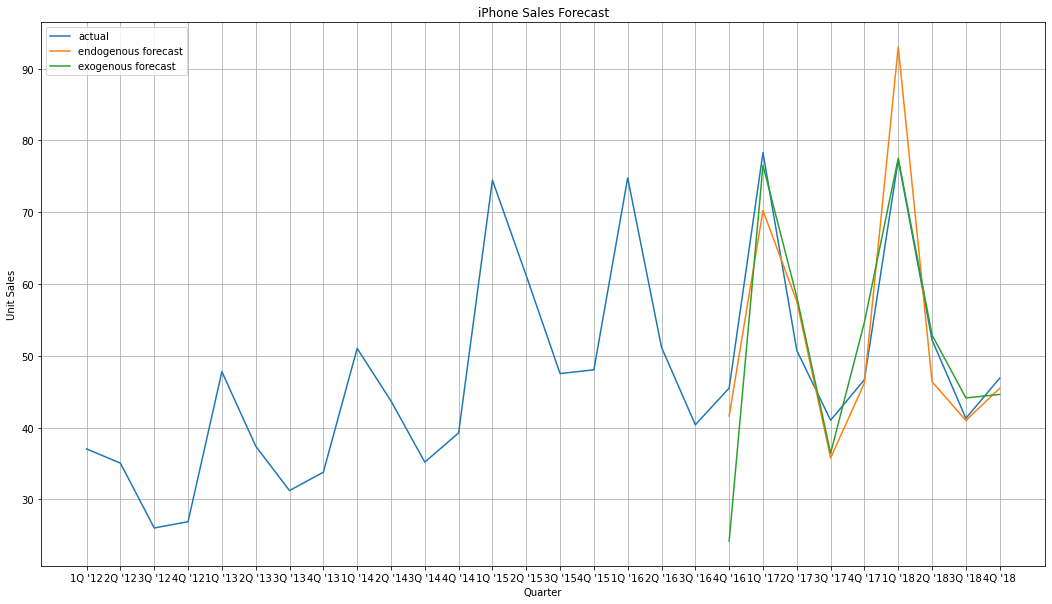

In [216]:
# plot
y_true = sales_df['iPhone']

fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], y_true, label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], bert_forecasts['iPhone_endog'], label='endogenous forecast')
plt.plot(sales_df['Quarter'].iloc[train_idx:], bert_forecasts['iPhone'], label='exogenous forecast')

plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("iPhone Sales Forecast")
plt.grid(True)
plt.legend()

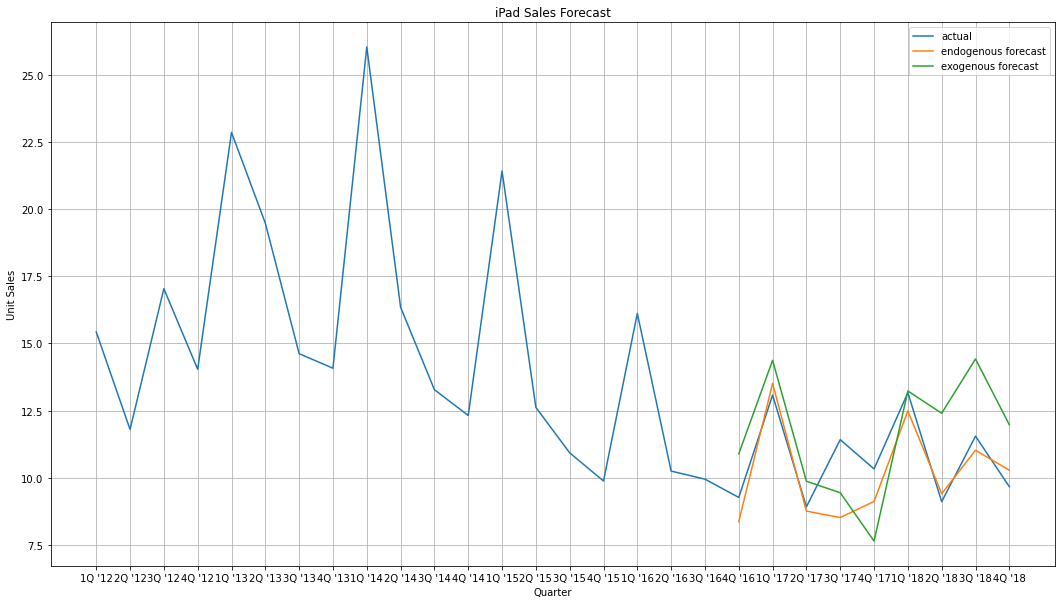

In [217]:
# plot
y_true = sales_df['iPad']

fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], y_true, label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], bert_forecasts['iPad_endog'], label='endogenous forecast')
plt.plot(sales_df['Quarter'].iloc[train_idx:], bert_forecasts['iPad'], label='exogenous forecast')

plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("iPad Sales Forecast")
plt.grid(True)
plt.legend()

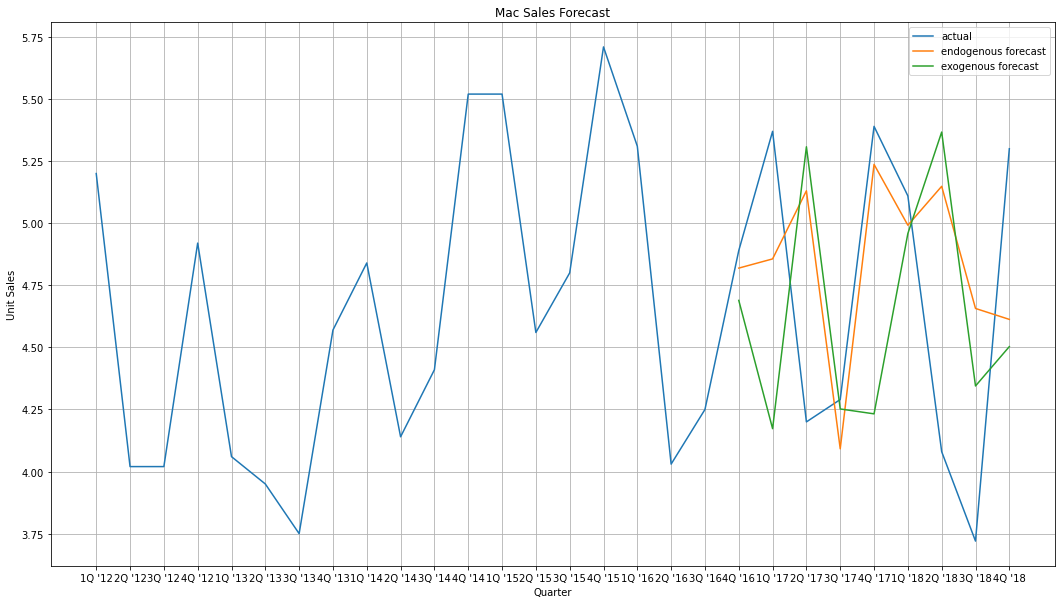

In [218]:
# plot
y_true = sales_df['Mac']

fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(sales_df['Quarter'], y_true, label='actual')
plt.plot(sales_df['Quarter'].iloc[train_idx:], bert_forecasts['Mac_endog'], label='endogenous forecast')
plt.plot(sales_df['Quarter'].iloc[train_idx:], bert_forecasts['Mac'], label='exogenous forecast')

plt.xlabel("Quarter")
plt.ylabel("Unit Sales")
plt.title("Mac Sales Forecast")
plt.grid(True)
plt.legend()

To do: modularise code